In [1]:
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints._base import Endpoint
from nba_api.stats.library.http import NBAStatsHTTP
from nba_api.stats.endpoints import playerdashboardbyteamperformance
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import teamdashboardbyteamperformance
from nba_api.stats.endpoints import playerdashboardbylastngames
from nba_api.stats.endpoints import playerdashboardbyyearoveryear
from nba_api.stats.endpoints import teamdashboardbylastngames
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.static import teams
from nba_api.stats.static import players
import pandas as pd
import inspect
import numpy as np
import csv
import sys

import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

headers = { 'Host': 'stats.nba.com', 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:61.0) Gecko/20100101 Firefox/61.0', 'Accept': 'application/json, text/plain, /', 'Accept-Language': 'en-US,en;q=0.5', 'Referer': 'https://stats.nba.com/', 'Accept-Encoding': 'gzip, deflate, br', 'Connection': 'keep-alive', }

In [ ]:
#Enter Team1

team1_input = input('Enter team 1: ')

print(team1_input)

team1 = teams.find_teams_by_full_name(team1_input)[0]['id']

team1_dashboard_adv = teamdashboardbylastngames.TeamDashboardByLastNGames(team_id=team1, season='2019-20', 
                                                                    measure_type_detailed_defense='Advanced', 
                                                                        last_n_games=5, headers=headers)

team1_headers = team1_dashboard_adv.overall_team_dashboard.get_dict().get('headers')
team1_data = team1_dashboard_adv.overall_team_dashboard.get_dict().get('data')[0]

print(team1, '\n', team1_headers[7], team1_data[7], '\n', 
      team1_headers[8], team1_data[8], '\n',
      team1_headers[9], team1_data[9], '\n', 
      team1_headers[10], team1_data[10])

E_OFF1_RATING = team1_data[7]
OFF1_RATING = team1_data[8]
E_DEF1_RATING = team1_data[9]
DEF1_RATING = team1_data[10]

In [ ]:
#Enter Team2
team2_input = input('Enter team 2: ')
print(team2_input)

team2 = teams.find_teams_by_full_name(team2_input)[0]['id']

team2_dashboard_adv = teamdashboardbylastngames.TeamDashboardByLastNGames(team_id=team2, season='2019-20', 
                                                                    measure_type_detailed_defense='Advanced', 
                                                                        last_n_games=5, headers=headers)

team2_headers = team2_dashboard_adv.overall_team_dashboard.get_dict().get('headers')
team2_data = team2_dashboard_adv.overall_team_dashboard.get_dict().get('data')[0]

print(team2, '\n', team2_headers[7], team2_data[7], '\n', 
      team2_headers[8], team2_data[8], '\n',
      team2_headers[9], team2_data[9], '\n', 
      team2_headers[10], team2_data[10])

E_OFF2_RATING = team2_data[7]
OFF2_RATING = team2_data[8]
E_DEF2_RATING = team2_data[9]
DEF2_RATING = team2_data[10]

In [60]:
#Load Rosters
roster1 = teamplayerdashboard.TeamPlayerDashboard(team_id=team1, last_n_games=1, 
                                                  season='2019-20', headers=headers).get_dict()#.PlayersSeasonTotals(team_id=team1, last_n_games=20)
roster2 = teamplayerdashboard.TeamPlayerDashboard(team_id=team2, last_n_games=1, 
                                                  season='2019-20', headers=headers).get_dict()#.PlayersSeasonTotals(team_id=team1, last_n_games=20) 

team1_roster_last20 = []
team1_roster_lastn = []
team2_roster_lastn = []

for n in roster1['resultSets'][1]['rowSet']:
    print(n[2], 'GP:', n[3], 'id:', n[1], 'Min', n[7])
    team1_roster_lastn.append(n[2])

for n in roster2['resultSets'][1]['rowSet']:
    print(n[2], 'GP:', n[3], 'id:', n[1], 'Min', n[7])
    team2_roster_lastn.append(n[2])
    
print(team1_roster_lastn, '\n',
     team2_roster_lastn)
#(PER * MP)/n_players

Bradley Beal GP: 1 id: 203078 Min 29.65
CJ Miles GP: 1 id: 101139 Min 21.283333333333335
Chris Chiozza GP: 1 id: 1629185 Min 1.8166666666666667
Davis Bertans GP: 1 id: 202722 Min 22.533333333333335
Isaac Bonga GP: 1 id: 1629067 Min 5.85
Isaiah Thomas GP: 1 id: 202738 Min 21.85
Ish Smith GP: 1 id: 202397 Min 20.3
Jordan McRae GP: 1 id: 203895 Min 23.883333333333333
Moritz Wagner GP: 1 id: 1629021 Min 25.25
Rui Hachimura GP: 1 id: 1629060 Min 22.016666666666666
Thomas Bryant GP: 1 id: 1628418 Min 22.75
Troy Brown Jr. GP: 1 id: 1628972 Min 22.816666666666666
Gary Harris GP: 1 id: 203914 Min 28.366666666666667
Jamal Murray GP: 1 id: 1627750 Min 24.933333333333334
Jerami Grant GP: 1 id: 203924 Min 28.183333333333334
Juancho Hernangomez GP: 1 id: 1627823 Min 11.75
Malik Beasley GP: 1 id: 1627736 Min 18.866666666666667
Mason Plumlee GP: 1 id: 203486 Min 23.11
Monte Morris GP: 1 id: 1628420 Min 23.066666666666666
Nikola Jokic GP: 1 id: 203999 Min 24.89
Paul Millsap GP: 1 id: 200794 Min 19.8166

In [61]:
#Individual Off and Def Ratings

def off_def_per_calc(team):
    
    player_info_off = leaguedashplayerstats.LeagueDashPlayerStats(last_n_games=5, season='2019-20', 
                                                                  measure_type_detailed_defense='Advanced')

    player_off_headers = player_info_off.league_dash_player_stats.get_dict().get('headers')
    player_off_data = player_info_off.league_dash_player_stats.get_dict().get('data')

#     print('headers:', player_off_headers)

    for p in team:
        for n in player_off_data:
            if p in n:
                print(n[1], '\n', 'Min', n[9], 
                      'E_Off_Rating', n[10], 'E_Def_Rating', n[13])

In [62]:
off_def_per_calc(team1_roster_lastn)
print('\n')
off_def_per_calc(team2_roster_lastn)

Bradley Beal 
 Min 38.2 E_Off_Rating 111.0 E_Def_Rating 114.9
CJ Miles 
 Min 15.5 E_Off_Rating 110.7 E_Def_Rating 124.3
Chris Chiozza 
 Min 1.8 E_Off_Rating 133.3 E_Def_Rating 66.7
Davis Bertans 
 Min 28.4 E_Off_Rating 118.8 E_Def_Rating 116.0
Isaac Bonga 
 Min 3.2 E_Off_Rating 163.7 E_Def_Rating 112.5
Isaiah Thomas 
 Min 25.0 E_Off_Rating 106.1 E_Def_Rating 119.3
Ish Smith 
 Min 22.8 E_Off_Rating 115.0 E_Def_Rating 112.2
Jordan McRae 
 Min 20.2 E_Off_Rating 120.4 E_Def_Rating 106.0
Moritz Wagner 
 Min 20.8 E_Off_Rating 109.8 E_Def_Rating 118.6
Rui Hachimura 
 Min 24.0 E_Off_Rating 110.5 E_Def_Rating 116.1
Thomas Bryant 
 Min 27.1 E_Off_Rating 113.8 E_Def_Rating 112.9
Troy Brown Jr. 
 Min 20.2 E_Off_Rating 100.6 E_Def_Rating 114.2


Gary Harris 
 Min 30.8 E_Off_Rating 115.2 E_Def_Rating 98.1
Jamal Murray 
 Min 32.4 E_Off_Rating 115.5 E_Def_Rating 96.9
Jerami Grant 
 Min 21.9 E_Off_Rating 104.4 E_Def_Rating 105.1
Juancho Hernangomez 
 Min 16.8 E_Off_Rating 105.0 E_Def_Rating 104.5
Malik

In [ ]:
data = pd.read_csv("NBA Merged Sheets - Sheet2.csv") 
data_t = pd.read_csv("team_stats_basic_2018-19.csv")
df = pd.read_csv("team 2018-19.csv") 

teams = ['ATL', 'IND', 'MIL', 'ORL', 'PHI', 'SAS', 'POR', 'NOP', 'UTA', 'HOU', 'BOS', 
         'MEM', 'BKN', 'MIA', 'CHI', 'MIN', 'PHX', 'DET', 'NYK', 'LAL', 'CHA', 'TOR', 
         'WAS', 'SAC', 'LAC', 'OKC', 'CLE', 'DAL', 'DEN', 'GSW']

In [ ]:
def regression(team):
    
    with open('regression_list.csv', 'a', newline='') as csvFile:
        writer = csv.writer(csvFile)
        headers = ['Team1','T1_OR5', 'T1_DR5', 'Team2', 'T2_OR5', 'T2_DR5', 'Spread', 'TScore']
        writer.writerow(headers)
    csvFile.close() 
    
    team2 = []
    date = []

    score = []

    df2 = df[['Team', 'Matchup', 'Date', 'OffRtg', 'DefRtg', 'ASTRatio', 'PACE']]
    df2 = df[df['Team'] == team1]

    opp = []

    team2 = df2['Matchup']

    for row in team2:
        opp.append(row.replace(team1+'vs.', '').replace(team1+'@', ''))

    df2['Opp'] = opp

    team1_off_avg = 0
    team1_def_avg = 0

    team2_off_avg = 0
    team2_def_avg = 0
    totalscore = 0

    for index, row in df2.head(n=77).iterrows(): 
        whole_row = []
        team2 = row['Opp']
        date = row['Date']
        df3 = df[df['Team'] == team2]

        score = data.loc[(data['DATE']==date) & (data['TEAM']==team1)]
        score = score.iloc[0]
        score = (score["team_pts"], score['team_plus_minus'])
        print('===', row['Team'], row['OffRtg'], row['DefRtg'], 
              row['Date'], row['Opp'], score, "===") 
                
        print(row['Team'], 'Last5_Off', row['Last5_Off'], 'Last5_Def', row['Last5_Def'])
        whole_row.append(row['Team'])
        whole_row.append(row['Last5_Off'])
        whole_row.append(row['Last5_Def'])

        df3 = df3.loc[df3['Date'] == date]
        for index, row in df3.iterrows():
            print(row['Team'], 'Last5_Off', row['Last5_Off'], 'Last5_Def', row['Last5_Def'], '\n')
            whole_row.append(row['Team'])
            whole_row.append(row['Last5_Off'])
            whole_row.append(row['Last5_Def'])
            whole_row.append(score[1])
            whole_row.append(score[0]-score[1]+score[0])
            
            with open('regression_list.csv', 'a') as csvFile:
                writer = csv.writer(csvFile)
                writer.writerow(whole_row)
            csvFile.close() 

In [ ]:
for team in teams:
    regression(team)

In [4]:
rdf = pd.read_csv("regression_list.csv") 
rdf

,Team1,T1_OR5,T1_DR5,Team2,T2_OR5,T2_DR5,Spread,TScore
0,ATL,110.22,117.62,IND,108.68,110.44,-1.0,269.0
1,ATL,110.00,119.68,MIL,118.16,113.78,-8.0,222.0
2,ATL,112.46,113.90,ORL,111.90,113.60,-36.0,262.0
3,ATL,110.68,113.52,PHI,110.46,114.72,8.0,252.0
4,ATL,111.00,112.52,SAS,113.02,111.18,-6.0,228.0
5,ATL,108.94,113.40,MIL,114.66,101.26,1.0,271.0
6,ATL,106.50,109.10,POR,121.96,112.64,-20.0,216.0
7,ATL,106.36,112.62,NOP,103.12,114.46,10.0,250.0
8,ATL,109.04,111.30,PHI,117.32,111.14,2.0,256.0
9,ATL,111.58,112.10,UTA,120.08,101.46,3.0,231.0


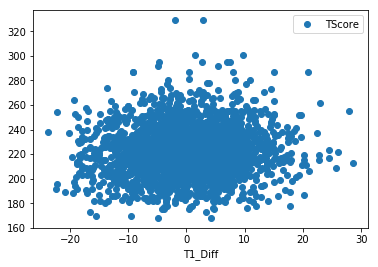

In [7]:
rdf = pd.read_csv("regression_list.csv") 

rdf['T1_Diff'] = rdf.T1_OR5 - rdf.T1_DR5
rdf['T2_Diff'] = rdf.T2_OR5 - rdf.T2_DR5

rdf.T1_OR5 = pd.to_numeric(rdf.T1_OR5)
rdf.T1_DR5 = pd.to_numeric(rdf.T1_DR5)
rdf.T2_OR5 = pd.to_numeric(rdf.T2_OR5)
rdf.T2_DR5 = pd.to_numeric(rdf.T2_DR5)
rdf.T1_Diff = pd.to_numeric(rdf.T1_Diff)

# rdf.plot(x='T1_Diff', y='TScore', style='o')  
# plt.show()
# rdf.plot(x='T2_Diff', y='Spread', style='o')  
# plt.show()

In [9]:
from pandas import DataFrame
from sklearn import linear_model
import statsmodels.api as sm

X = rdf[['T1_OR5','T1_DR5', 'T2_OR5', 'T2_DR5']] # here we have 2 variables for multiple regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example.Alternatively, you may add additional variables within the brackets
Y = rdf['Spread']
Y2 = rdf['TScore']

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

regr2 = linear_model.LinearRegression()
regr2.fit(X, Y2)

print('Intecept_Score: \n', regr2.intercept_)
print('Coefficients_Score: \n', regr2.coef_)


Intercept: 
 0.1968372047350489
Coefficients: 
 [ 0.42950031 -0.40077189 -0.43303045  0.40262237]
Intecept_Score: 
 96.94754180172698
Coefficients_Score: 
 [0.42136938 0.15357508 0.41373199 0.15386099]


/Users/stan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [45]:
# prediction with sklearn
#https://stats.nba.com/team/1610612763/advanced/?Season=2019-20&SeasonType=Regular%20Season&Split=lastn

New_T1_OR5 = E_OFF1_RATING
New_T1_DR5 = E_DEF1_RATING

New_T2_OR5 = E_OFF2_RATING
New_T2_DR5 = E_DEF2_RATING

print('Predicted Spread: \n', regr.predict([[New_T1_OR5 ,New_T1_DR5, New_T2_OR5, New_T2_OR5 ]]))
print('Predicted Over/Under: \n', regr2.predict([[New_T1_OR5 ,New_T1_DR5, New_T2_OR5, New_T2_OR5 ]])) 

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Predicted Spread: 
 [3.73575207]
Predicted Over/Under: 
 [222.66320855]
                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     64.67
Date:                Wed, 27 Nov 2019   Prob (F-statistic):           6.76e-52
Time:                        00:35:54   Log-Likelihood:                -9365.1
No. Observations:                2310   AIC:                         1.874e+04
Df Residuals:                    2305   BIC:                         1.877e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [ ]:
#Theory: If second game of back-to-back is a road game, odds of winning decrease 7-8%, multiply ratings by 0.93.